In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta

In [2]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
df = pd.read_excel('biometria.xlsx', sheet_name='Página1')
print(df.tail(10))

     Index    peso  comprimento_Total  comprimento_Padrao  comprimento_Cabeca  \
468  469.0  236.19               21.0                17.8                 6.1   
469  470.0  249.27               21.8                18.3                 5.6   
470  471.0  273.14               22.7                18.6                 5.6   
471  472.0  243.25               22.1                18.8                 6.7   
472  473.0  217.25               21.4                18.3                 5.4   
473  474.0  248.22               22.3                18.6                 6.0   
474  475.0  220.84               21.4                18.1                 6.0   
475  476.0  238.77               22.5                18.4                 6.4   
476  477.0  248.32               21.9                18.5                 5.8   
477  478.0  256.82               22.0                18.6                 6.0   

     altura  espessura       data  
468     7.4        3.1 2024-05-02  
469     7.6        3.1 2024-05-02  


In [3]:
df2 = df.drop(columns=[
'data', 
'Index',
'espessura'
])
df2.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura
0,51.45,14.3,12.2,4.0,4.1
1,37.15,12.4,10.9,3.8,3.2
2,47.26,13.7,11.2,3.4,4.0
3,36.67,12.9,11.1,3.7,3.7
4,45.48,13.2,11.3,3.8,4.5


In [31]:
####### BLIND TEST

#data = df2.sample(frac=0.95, random_state=123)
#data_unseen = df2.drop(data.index)

#data.reset_index(drop=True, inplace=True)
#data_unseen.reset_index(drop=True, inplace=True)

#print('Data for Modeling: ' + str(data.shape))
#print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (454, 5)
Unseen Data For Predictions: (24, 5)


In [4]:
from pycaret.regression import *
#### DATA for BLIND TEST
#exp2= setup(data = data,  target = 'peso')

exp2= setup(data = df2,  target = 'peso')
best_model = exp2.compare_models()

,Description,Value
0,Session id,8604
1,Target,peso
2,Target type,Regression
3,Original data shape,"(478, 5)"
4,Transformed data shape,"(478, 5)"
5,Transformed train set shape,"(334, 5)"
6,Transformed test set shape,"(144, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.6586,110.6314,10.2407,0.9807,0.0650,0.0521,0.0510
et,Extra Trees Regressor,6.5956,113.1232,10.3024,0.9799,0.0660,0.0520,0.0370
ada,AdaBoost Regressor,7.6194,114.4180,10.5239,0.9798,0.0923,0.0753,0.0310
gbr,Gradient Boosting Regressor,6.9050,118.7228,10.6389,0.9791,0.0672,0.0535,0.0260
lightgbm,Light Gradient Boosting Machine,7.1734,124.6798,10.8257,0.9783,0.0665,0.0542,0.0610
xgboost,Extreme Gradient Boosting,7.7350,149.3598,11.9721,0.9739,0.0736,0.0593,0.0830
dt,Decision Tree Regressor,8.8034,179.9014,13.1674,0.9684,0.0834,0.0680,0.0070
ridge,Ridge Regression,11.0614,193.5480,13.7868,0.9656,0.2841,0.1343,0.0070
br,Bayesian Ridge,11.0320,193.4824,13.7849,0.9656,0.2840,0.1339,0.0090
lr,Linear Regression,11.0052,193.4377,13.7837,0.9656,0.2839,0.1335,0.4820


In [5]:
rf = exp2.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.7557,137.2795,11.7166,0.9736,0.0838,0.0677
1,7.1798,120.3889,10.9722,0.9763,0.0721,0.0603
2,4.8387,59.6691,7.7246,0.9876,0.0571,0.0470
3,9.5381,201.6227,14.1994,0.9697,0.0763,0.0589
4,4.6200,41.0758,6.4090,0.9924,0.0558,0.0470
5,7.6409,131.8246,11.4815,0.9754,0.0686,0.0550
6,7.4252,167.2615,12.9330,0.9749,0.0601,0.0454
7,6.6803,113.6823,10.6622,0.9834,0.0637,0.0498
8,6.0080,75.0839,8.6651,0.9841,0.0621,0.0520


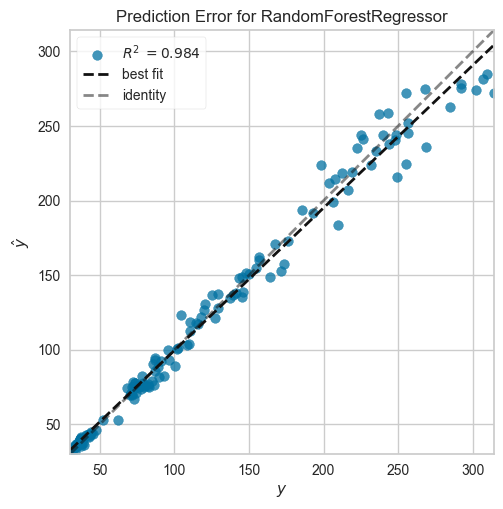

In [ ]:
exp2.plot_model(rf, plot = 'error')

In [6]:
exp2.evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [7]:
peso_pred_semEspe = exp2.predict_model(rf)
peso_pred_semEspe.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.7390,75.1253,8.6675,0.9844,0.0585,0.0469


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
310,18.600000,16.200001,5.1,5.5,141.240005,134.673602
183,15.700000,13.500000,4.0,4.6,76.629997,75.622801
390,20.799999,18.000000,6.0,6.8,216.149994,206.631199
81,11.900000,10.000000,3.1,3.9,37.779999,33.515799
260,19.200001,16.299999,4.8,5.4,148.199997,141.540898


In [9]:
### Saving model 

save_model(rf, 'rf_weight') 


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['comprimento_Total',
                                              'comprimento_Padrao',
                                              'comprimento_Cabeca', 'altura'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=8604))]),
 'rf_weight.pkl')

In [10]:
################### LOADING MODEL
saved_rf = load_model('rf_weight') 

saved_rf 

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\crist\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['comprimento_Total',
                                             'comprimento_Padrao',
                                             'comprimento_Cabeca', 'altura'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 RandomForestRegressor(n_jobs=-1, random_state=8604))])

In [11]:
exp2.predict_model(saved_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.7390,75.1253,8.6675,0.9844,0.0585,0.0469


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
310,18.600000,16.200001,5.1,5.5,141.240005,134.673602
183,15.700000,13.500000,4.0,4.6,76.629997,75.622801
390,20.799999,18.000000,6.0,6.8,216.149994,206.631199
81,11.900000,10.000000,3.1,3.9,37.779999,33.515799
260,19.200001,16.299999,4.8,5.4,148.199997,141.540898
...,...,...,...,...,...,...
344,17.799999,15.300000,5.0,5.2,112.050003,121.647966
149,14.400000,12.700000,4.0,4.6,65.550003,63.919449
112,13.200000,11.000000,3.2,3.9,39.990002,40.667999
351,18.799999,16.100000,5.1,5.4,144.789993,136.345800


In [12]:
##################### BLIND TEST
#pred_unseen = predict_model(rf, data = data_unseen)
#pred_unseen.head(5)